# Discrete Logarithm

The Discrete Logarithm Problem [[1](#DiscreteLog)] was shown by Shor [[2](#Shor)] to be solved in a polynomial time using quantum computers, while the fastest classical algorithms take a superpolynomial time. The problem is at least as hard as the factoring problem. In fact, the hardness of the problem is the basis for the Diffie-Hellman [[3](#DiffieHellman)]] protocol for key exchange. 

### Problem formulation

* **Input:** A cyclic group $G = \langle g \rangle$ with $g$ as a generator, and an element $x\in G$.

* **Promise:**  There is a number $s$ such that $g^s = x$.

* **Output:** $s$, the discrete logarithm: $s = \log_gx$

*** 

In Shor's implementation the order of $g$ is assumed to be known beforehand (for example using the order finding algorithm). We will also assume it in the demonstration. 

The Discrete Log problem is a specific example for the Abelian Hidden Subgroup Problem [[4](#HSP)], for the case where G is the additive group $\mathbb{Z}_N \times \mathbb{Z}_N$, with the function:
$$
f(\alpha, \beta) = x^\alpha g^\beta
$$

## How to build the Algorithm with Classiq

The heart of the algorithm's logic is the implementation of the function:
$$
|x_1\rangle|x_2\rangle|1\rangle \rightarrow |x_1\rangle|x_2\rangle|x^{x_1} g^{x_2}\rangle 
$$

This is done using 2 applications of the modular exponentiation function, which was described in detail in the [Shor's Factoring Algorithm](https://github.com/Classiq/classiq-library/blob/main/algorithms/algebraic/shor/shor_modular_exponentiation.ipynb) notebook. So here we will just import it from the classiq's library.

The function `modular_exp` accepts the following arguments:
- `n: CInt` - modulo number
- `a: CInt` - base of the exponentiation
- `x: QArray[QBit]` - unsigned integer to multiply be the exponentiation
- `power: QArray[QBit]`- power of the exponentiation

So that the function implements:
$|power\rangle|x\rangle \rightarrow |power\rangle|x \cdot a ^ {power}\mod n\rangle$

In [1]:
from classiq.qmod import (
    CInt,
    Output,
    QArray,
    QBit,
    QNum,
    allocate,
    inplace_prepare_int,
    modular_exp,
    qfunc,
)


@qfunc
def discrete_log_oracle(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    x1: QArray[QBit],
    x2: QArray[QBit],
    func_res: Output[QArray[QBit]],
) -> None:

    allocate(ceiling(log(N, 2)), func_res)

    inplace_prepare_int(1, func_res)
    modular_exp(N, x, func_res, x1)
    modular_exp(N, g, func_res, x2)

### The full algorithm:
1. Prepare uniform superposition over the first 2 quantum variables `x1`, `x2`. Each variable should be with size $\lceil \log r\rceil + \log({1/{\epsilon}})$. In the special case where $r$ is a power of 2,  $\log r$ is enough.
3. Compute `discrete_log_oracle` on the `func_res` variable. `func_res` should be of size $\lceil \log N\rceil$.
4. Apply inverse Fourier transform `x1`, `x2`.
5. Measure.

In [2]:
from classiq.qmod import hadamard_transform, invert, qft
from classiq.qmod.symbolic import ceiling, log


@qfunc
def discrete_log(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    x1: Output[QArray[QBit]],
    x2: Output[QArray[QBit]],
    func_res: Output[QArray[QBit]],
) -> None:
    reg_len = ceiling(log(order, 2))
    allocate(reg_len, x1)
    allocate(reg_len, x2)

    hadamard_transform(x1)
    hadamard_transform(x2)

    discrete_log_oracle(g, x, N, order, x1, x2, func_res)

    invert(lambda: qft(x1))
    invert(lambda: qft(x2))

After the inverse QFTs, we get in the variables (under the assumption of $r=2^m$ for some $m$):
$$|\psi\rangle = \sum_{\nu\in\mathbb{Z}_r, \delta\in G}\omega^{\nu\delta}|\nu log_gx\rangle_{x_1}|\nu\rangle_{x_2}|\delta>_{func\_res}$$

For every $\nu$ that has a mutplicative inverse in $\mathbb{Z}_r$, we can extract $s=\log_xg$ by multiplying the first variable result by its inverse.

In the case where $r$ is not a power of 2, we get in the variables and approximation of: |$ \log_g(x) \nu/ r\rangle_{x_1} |\nu / r\rangle_{x_2}$. So we can use the continued fractions algorithm [[5](#ContinuedFraction)] to compute $\nu/r$, then using the same technique to calculate $\log_gx$.

*Note: Alternatively, one might implement the $QFT_{\mathbb{Z}_r}$ over general $r$, and instead of the uniform superposition prepare the states: $\frac{1}{\sqrt{r}}\sum_{x\in\mathbb{r}}|x\rangle$ in `x1`, `x2`. Then again no continued fractions post-process is required.*

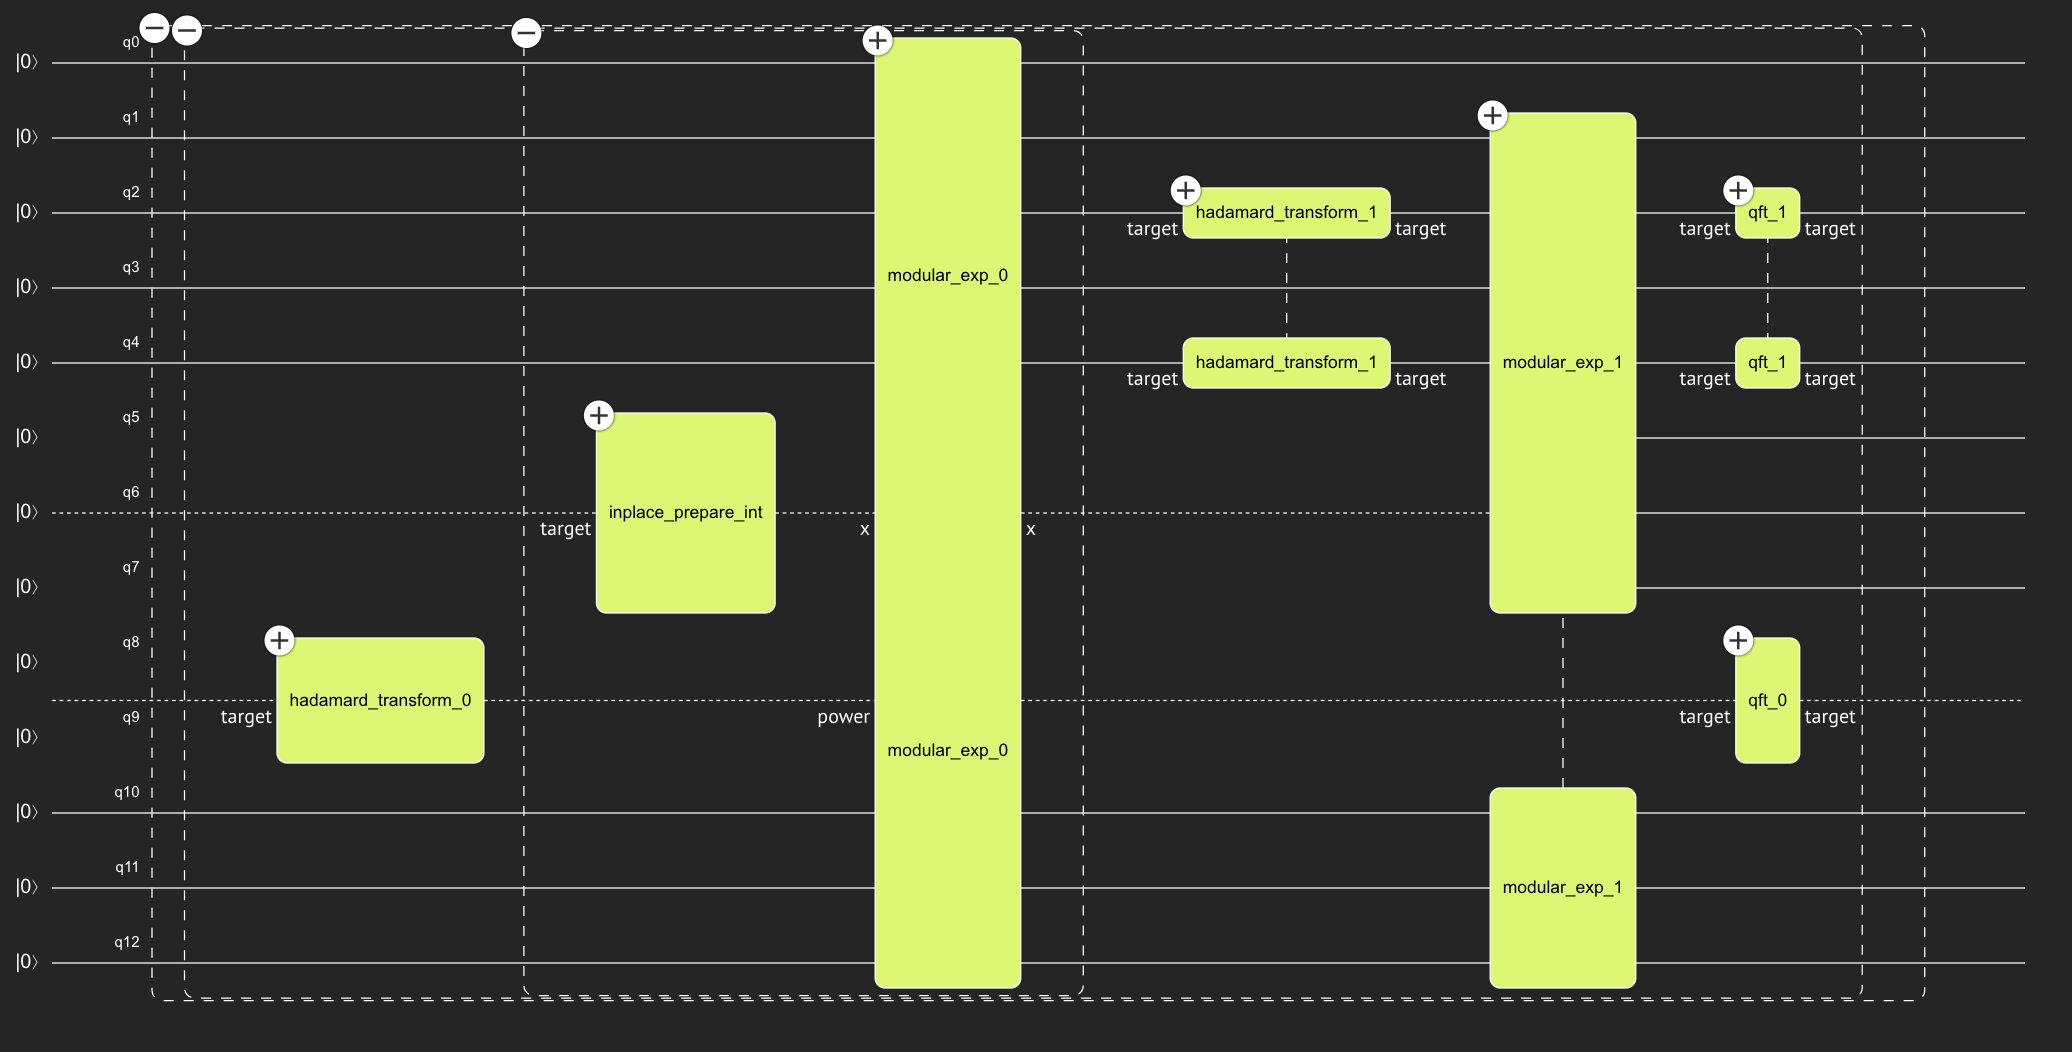

## Example:  $G = \mathbb{Z}_5^\times$

For this specific demonstration, we choose $G = \mathbb{Z}_5^\times$, with $g=3$ and $x=2$. Under this setting, $log_gx=3$.

We choose this specific example as the order of of the group $r=4$ is a power of $2$, and so we can get exactly the discrete logarithm, without continued-fractions post processing. In other cases, one has to use larger quantum variable for the exponents so the continued fractions post-processing will converge.

In [3]:
from classiq import Constraints, create_model

MODULU_NUM = 5
G = 3
X = 2
ORDER = MODULU_NUM - 1  # as 5 is prime


@qfunc
def main(
    x1: Output[QNum],
    x2: Output[QNum],
    func_res: Output[QNum],
) -> None:
    discrete_log(G, X, MODULU_NUM, ORDER, x1, x2, func_res)

In [4]:
from classiq import Preferences, show, synthesize, write_qmod

constraints = Constraints(max_width=13)
qmod = create_model(main, constraints=constraints)
write_qmod(qmod, "discrete_log")

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/2f88183e-39d4-4d7d-8a4c-fc6acdce4b40?version=0.41.0.dev39%2B79c8fd0855


In [5]:
from classiq import execute

results = execute(qprog).result()
res = results[0].value
res.parsed_counts

[{'x1': 2.0, 'x2': 2.0, 'func_res': 2.0}: 78,
 {'x1': 2.0, 'x2': 2.0, 'func_res': 1.0}: 77,
 {'x1': 0.0, 'x2': 0.0, 'func_res': 2.0}: 73,
 {'x1': 3.0, 'x2': 1.0, 'func_res': 2.0}: 72,
 {'x1': 3.0, 'x2': 1.0, 'func_res': 1.0}: 69,
 {'x1': 1.0, 'x2': 3.0, 'func_res': 4.0}: 68,
 {'x1': 0.0, 'x2': 0.0, 'func_res': 4.0}: 62,
 {'x1': 1.0, 'x2': 3.0, 'func_res': 2.0}: 60,
 {'x1': 3.0, 'x2': 1.0, 'func_res': 4.0}: 60,
 {'x1': 2.0, 'x2': 2.0, 'func_res': 4.0}: 58,
 {'x1': 1.0, 'x2': 3.0, 'func_res': 3.0}: 58,
 {'x1': 2.0, 'x2': 2.0, 'func_res': 3.0}: 57,
 {'x1': 0.0, 'x2': 0.0, 'func_res': 3.0}: 54,
 {'x1': 3.0, 'x2': 1.0, 'func_res': 3.0}: 54,
 {'x1': 0.0, 'x2': 0.0, 'func_res': 1.0}: 53,
 {'x1': 1.0, 'x2': 3.0, 'func_res': 1.0}: 47]

Notice that `func_res` is uncorrelated to the other variables, and we get uniform distribution, as expected. 

We take only the `x2` that are co-prime to $r=4$, so they have a multiplicative-inverse. Hence `x2=1,3` are the relevant results.
So we get 2 relevant results (for all different $\delta$s): $|1\rangle|3\rangle$, $|3\rangle|1\rangle$. All left to do to get the logarithm is to multiply `x1` by the inverse of `x2`:

In [6]:
print(3 * pow(1, -1, 4))

3


In [7]:
print(1 * pow(3, -1, 4))

3


In [8]:
print(3**3 % 5)

2


And indeed in both cases the same result, which is exactly the discrete logarithm: $\log_32 \mod 5 = 3$

## References

<a id='DiscreteLog'>[1]</a>: [Discrete Logarithm (Wikipedia)](https://en.wikipedia.org/wiki/Discrete_logarithm)

<a id='Shor94'>[2]</a>: [Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. Ieee, 1994.](https://ieeexplore.ieee.org/abstract/document/365700)

<a id='DiffieHellman'>[3]</a>: [Diffie-Hellman Key Exchange (Wikipedia)](https://en.wikipedia.org/wiki/Diffie%E2%80%93Hellman_key_exchange)

<a id='HSP'>[4]</a>: [Hidden Subgroup Problem (Wikipedia)](https://en.wikipedia.org/wiki/Hidden_subgroup_problem)

<a id='ContinuedFraction'>[5]</a>: [Continued Fraction (Wikipedia)](https://en.wikipedia.org/wiki/Continued_fraction)
